# Traffic Sign Recognizer - BIAI Project

## Zaimportowanie niezbędnych bibliotek

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import accuracy_score
#np.random.seed(42) #ziarno do generatora liczb pseudolosowych. Jeżeli chcesz, żeby za każdym uruchomieniem programu wartości były różne, zakomentuj

from matplotlib import style
style.use('Solarize_Light2') #ustawienie stylu wykresów

## Przyporządkowanie ścieżek datasetu

In [2]:
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'

# Zmieniamy domyślne wymiary obrazów na 30x30
# Użycie wymiarów 60x60 wydłuża czas działania programu ponad 3-krotnie
IMG_HEIGHT = 30
IMG_WIDTH = 30

## Wyszukanie liczby klas (podfolderów)

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path)) #ile podfolderów mamy w folderze Train (kazdy podfolder reprezentuje inną klasę)
NUM_CATEGORIES #43, od 0 do 42

43

## Podgląd klas

In [4]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Wizualizacja ilości danych w zbiorze

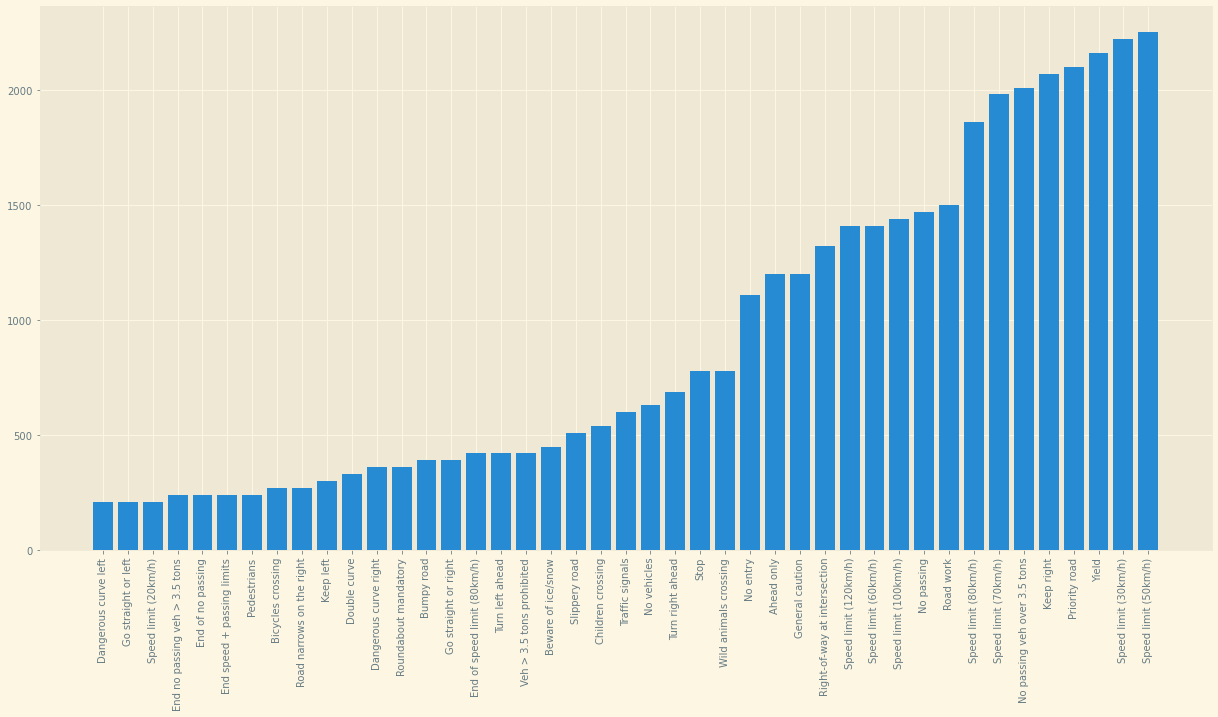

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sortowanie datasetu na podstawie ilośći obrazków w każdej klasie (podfolderze)
zipped_lists = zip(train_number, class_num) #łączymy listy w pary
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs) #rozdzielamy posortowane pary na dwie listy
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Wyświetlanie datasetu
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

## Wizualizacja losowo wybranych obrazków

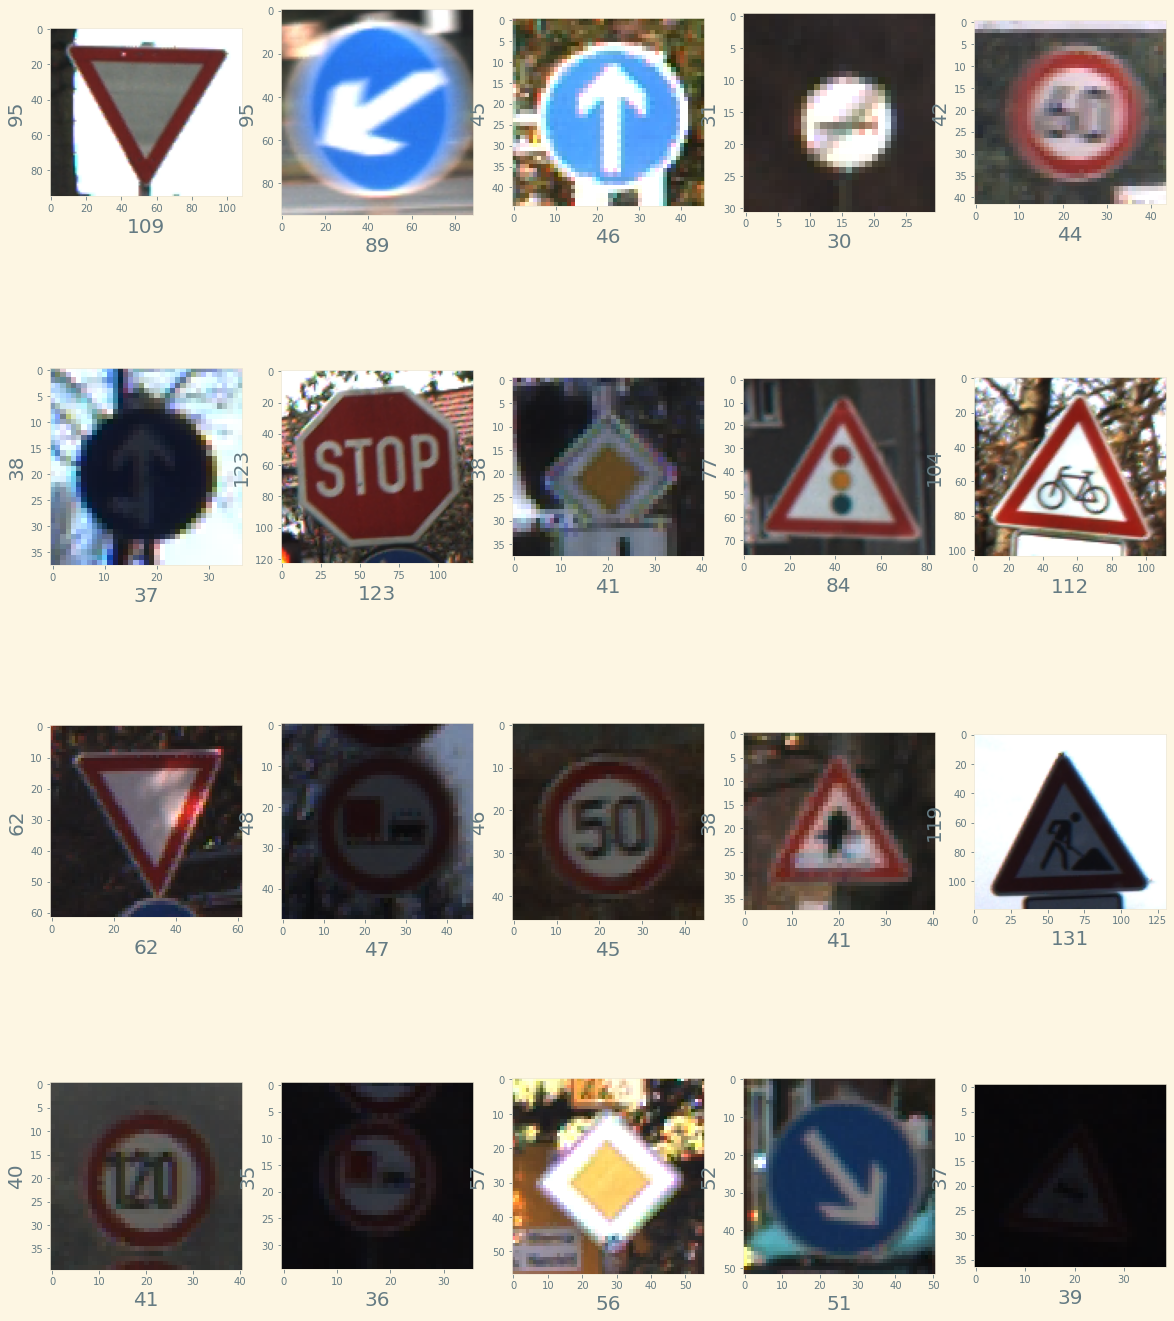

In [6]:
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values #pobranie wartości kolumny Path do zmiennej imgs

plt.figure(figsize=(20,25)) #wykres 25x25

for i in range(1,21):
    plt.subplot(4,5,i) #podwykres
    random_img_path = data_dir + '/' + random.choice(imgs) #obraz o losowej scieżce
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None) #wyłączamy siatkę
    plt.xlabel(rand_img.shape[1], fontsize = 20)#oś x szerokosc obrazu
    plt.ylabel(rand_img.shape[0], fontsize = 20)#oś y wysokosc obrazu

## Zebranie obrazków i odpowiadających im klas

In [7]:
image_data = [] #lista z danymi (obrazami w postaci array)
image_labels = [] #lista z klasami obrazów

for i in range(NUM_CATEGORIES):
    path = os.path.join(train_path, str(i))
    images = os.listdir(path) #lista zawartości każdego z podfolderów folderu train (czyli obrazki)
    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error przy znaku" + img)

# Zamieniamy listy na nump array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

# printujemy: dla data - liczbę obrazków[39209], wymiary [30x30] oraz info że są kolorowe [3] 
# dla labels - liczbę labeli w przypisaniu do obrazków (czyli różnych labeli jest tylko 43, ale każdy obrazek ma przypisany do siebie label)
print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Losujemy dane do treningu
### Dokonujemy przetasowania indeksów, identycznego dla tablic z obrazami i odpowiadającymi im labelami - tak aby danemu zdjęciu dalej odpowiadała ta sama przypisana wyżej klasa

In [8]:
shuffle_indexes = np.arange(image_data.shape[0]) #tworzymy jednowymiarową tablicę o dł. równej liczbie wierszy w image_data
np.random.shuffle(shuffle_indexes) #losowe przetasowanie wartości w tablicy

#indeksowanie image_data za pomocą losowo przetasowanych indeksów w shuffle_indexes
image_data = image_data[shuffle_indexes] 
image_labels = image_labels[shuffle_indexes] 

## Rozdzielamy datasety obrazków


In [9]:
# Dzielimy zbiory danych:
# w taki sposób, że labels będą targetem (czyli to co chcemy przewidzieć [poprawność określania labeli])
# test_size oznacza że do testów(walidacji) przydzielamy 20% datasetu, reszta idzie do treningu
# random_state - w zależności od ustawień:
# * przy każdym uruchomieniu programu możemy dostać powtarzalny podział danych (przydatne dla testowania różnych modeli)
# * gdy nie ustawimy parametru w ogóle przy każdym uruchomieniu programu podział będzie losowy
# * gdy ustawimy różne wartości przy każdym uruchomieniu programu, ale zbliżone (41,42,43) to podział danych będzie podobny, ale nie identyczny
# * gdy ustawimy różne wartości, oddalone od siebie (1, 900, 1523) dostaniemy całkowicie różne podziały
# x to rozdział data na dane treningowe i walidacyjne, y to analogiczny rozdział labels
# shuffle - ustawiamy przetasowanie danych na TRUE
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, shuffle=True)

# Normalizacja danych z zakresu pikseli 0-255 do zakresu 0-1. Jeżeli nie podzielimy przez 255, dane pozostaną w swojej pierwotnej wartości pikseli.
# Zalety normalizacji:
# * Ułatwia proces uczenia maszynowego 
# * Uniezależnienie od jednostek pikseli
# * Poprawa stabilności numerycznej
X_train = X_train/255
X_val = X_val/255

# Wypisanie informacji o rozmiarach tablic
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 30, 30, 3)
X_valid.shape (7842, 30, 30, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


## Konwersja klas na macierze binarne

In [10]:
# Każdej odmiennej wartości odpowiada inny wiersz np. 1,0,0,0. 
# Jeżeli wartość int się powtarza, to powtarza się również wiersz 1,0,0,0 w macierzy. 
# Kolumn jest tyle ile różnych wartości (czyli w naszym przypadku 43),
# a wierszy tyle ile wartości łącznie (czyli ponad 31 tys. dla y_t1 i ponad 7 tys. dla y_t2)
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(31367, 43)
(7842, 43)


## Budowa modelu CNN w celu podziału obrazów do odpowiednich kategorii

In [11]:
# Tworzymy nowy model sekwencyjny
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1), 
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
])

In [12]:
# Learning rate to parametr, który kontroluje, jak bardzo model ma dostosować wagi swoich połączeń na podstawie błędów, 
# które popełnia podczas treningu.
# Zbyt mały learning rate może spowodować, że model uczy się bardzo wolno lub może nawet zatrzymać się przed znalezieniem optymalnego rozwiązania. 
# Zbyt duży learning rate może prowadzić do oscylacji i niezbieżności modelu.
lr = 0.001 #ustawiamy learning rate na 0.001 (najczesciej wykorzystywana wartosc)

epochs = 15 #liczba epok

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #Kompilacja modelu

## Augmentacja danych i trenowanie modelu

In [13]:
# Korzystamy z augmentacji danych - techniki przetwarzania danych szczególnie popularnej w klasyfikacji obrazów
# Zwiększamy różnorodnośc danych treningowych, np. przez przesunięcie, obrót, zmianę rozmiaru obrazu
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

#W zależności od wartości batch_size będziemy mieli różną liczbę danych
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/15
981/981 [==============================] - 58s 59ms/step - loss: 0.9613 - accuracy: 0.7404 - val_loss: 0.1649 - val_accuracy: 0.9518
Epoch 2/15
981/981 [==============================] - 58s 59ms/step - loss: 0.1552 - accuracy: 0.9522 - val_loss: 0.0797 - val_accuracy: 0.9748
Epoch 3/15
981/981 [==============================] - 60s 61ms/step - loss: 0.0916 - accuracy: 0.9720 - val_loss: 0.0193 - val_accuracy: 0.9945
Epoch 4/15
981/981 [==============================] - 58s 59ms/step - loss: 0.0642 - accuracy: 0.9800 - val_loss: 0.0482 - val_accuracy: 0.9851
Epoch 5/15
981/981 [==============================] - 58s 59ms/step - loss: 0.0535 - accuracy: 0.9830 - val_loss: 0.0247 - val_accuracy: 0.9923
Epoch 6/15
981/981 [==============================] - 59s 60ms/step - loss: 0.0458 - accuracy: 0.9851 - val_loss: 0.0067 - val_accuracy: 0.9976
Epoch 7/15
981/981 [==============================] - 60s 61ms/step - loss: 0.0331 - accuracy: 0.9901 - val_loss: 0.0066 - val_accuracy:

## Generujemy wykres dla historii treningu modelu

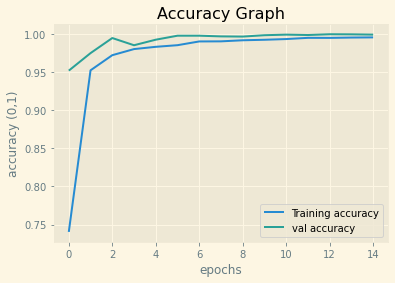

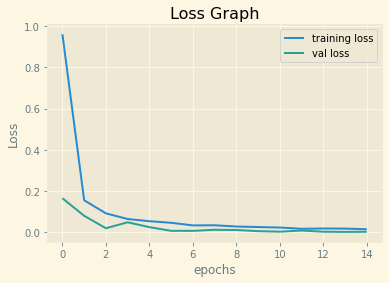

In [14]:
# POBAW SIĘ RÓŻNYMI WYKRESAMI, KTÓRY NAJŁADNIEJ I NAJBARDZIEJ PRZEJRZYŚCIE WYGLĄDA

#pd.DataFrame(history.history).plot(figsize=(8, 5)) # ustawia rozmiar wykresu na 8 cali szerokości i 5 cali wysokości.
#plt.grid(True) #dodajemy siatke do wykresu
#plt.gca().set_ylim(0, 1) #zakres osi y ograniczony od 0 do 1
#plt.show()
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy Graph")
plt.xlabel("epochs")
plt.ylabel("accuracy (0,1)")
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss Graph")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Pobieramy dane testowe i testujemy dokładność modelu na ich podstawie

In [15]:
test = pd.read_csv(data_dir + '/Test.csv') #odczytujemy plik csv z danymi testowymi

#pobieramy kolumny z pliku testowego i zapisujemy do odpowiednich tablic
labels = test["ClassId"].values 
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error dla obrazu: " + img)
X_test = np.array(data)
X_test = X_test/255 #normalizacja wartości pikseli tak aby były w zakresie 0 - 1

pred = model.predict_classes(X_test)

#Dokładność na podstawie danych testowych
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.1631037212985


## Wizualizacja macierzy pomyłek z wykorzystaniem heatmapy

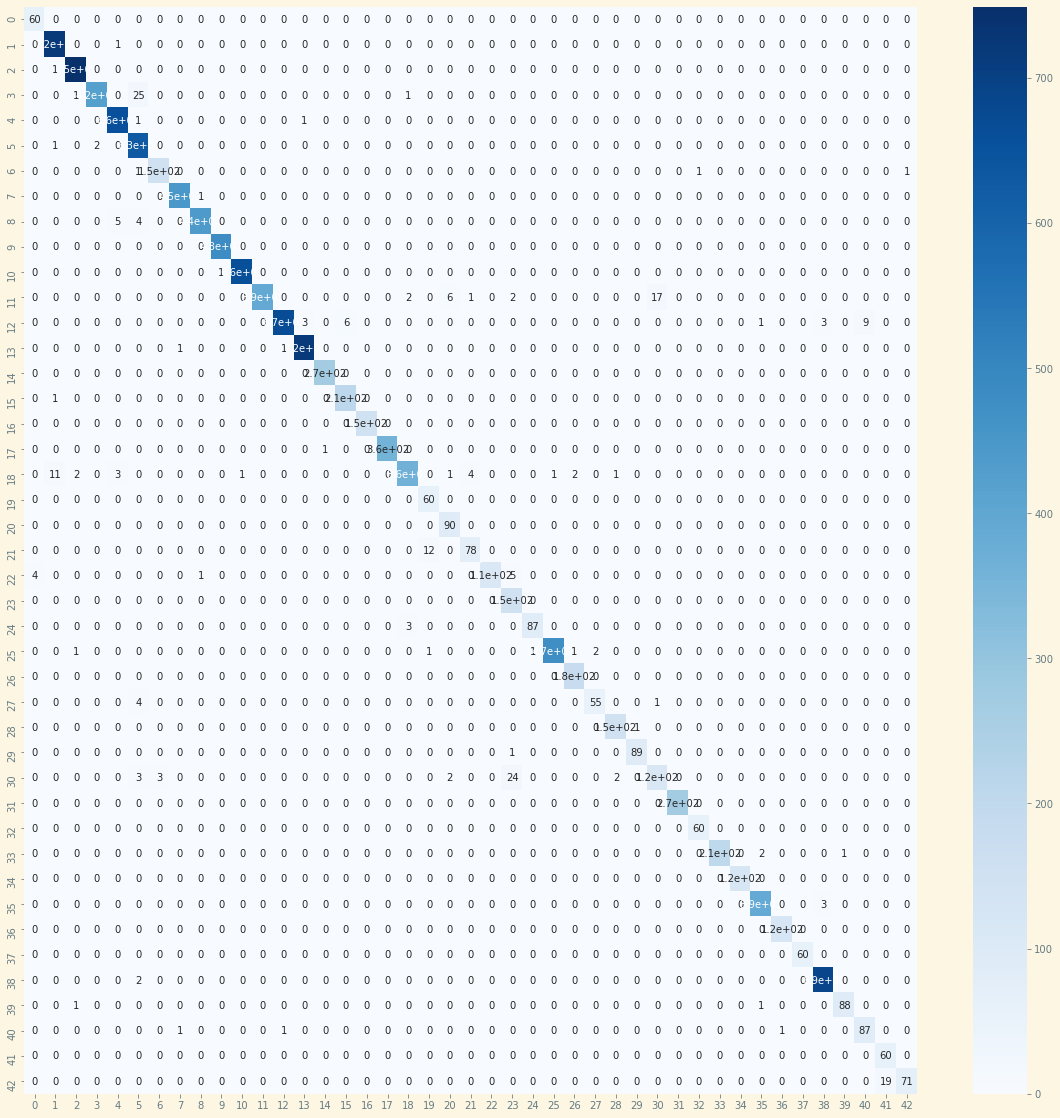

In [16]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True, cmap='Blues')

## Generujemy raport klasyfikacji

In [17]:
from sklearn.metrics import classification_report

# DO PRZEANALIZOWANIA TEN RAPORT DOKŁADNIE

# Dla każdej klasy raport klasyfikacji wyświetla wartości:
# Precyzja - miara proporcji poprawnie przewidzianych przypadków pozytywnych do wszystkich przypadków przewidzianych jako pozytywne
# Czułośc - miara proporcji poprawnie przewidzianych pozytywnych przypadków do wszystkich prawdziwie pozytywnych przypadków
# F1 - ważona średnia harmoniczna precyzji i czułości
# Współczynnik wsparcia - liczba wystąpień danej klasy w zbiorze testowym
print(classification_report(labels, pred))

#Saving the model
model.save('traffic_recognizer_final.h5')

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        60
           1       0.98      1.00      0.99       720
           2       0.99      1.00      1.00       750
           3       1.00      0.94      0.97       450
           4       0.99      1.00      0.99       660
           5       0.94      1.00      0.97       630
           6       0.98      0.98      0.98       150
           7       1.00      1.00      1.00       450
           8       1.00      0.98      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      0.93      0.97       420
          12       1.00      0.97      0.98       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.98       210
          16       1.00      1.00      1.00       150
          17       1.00    